In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(3456)

#### Hidden Layer: $h_j = \max{(W^{y}y_{j} + W^{t}t_{j} + W^{h}h_{j-1} + b_{h},0)} $


#### Marker Generation: $P(y_{j+1}=k\mid h_{j}) = \frac{\exp(V_{k,:}^{y}h_{j} + b_{k}^{y})}{\sum_{k=1}^{K} \exp(V_{k,:}^{y}h_{j} + b_{k}^{y})} = \sigma(z)_{k}$ where $\sigma$ is softmax function and $z$ is the vector $ V^{y}h_{j} + b^{y}$ 


#### Conditional Density: $f^{*}(t) = \exp\{{v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} + \frac{1}{w^t}\exp({v^{t}}^\top.h_{j} + b^{t}) -\frac{1}{w^t}\exp({v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} )\} $

In [12]:
marker = m(y)
marker = marker[0]
time = torch.tensor([0.1890])
hidden_state = torch.tensor([1.23423])
#input_ = torch.cat((marker, time, hidden_state))
markerx = marker[0].unsqueeze(-1)
markery = marker[1].unsqueeze(-1)
input_ = torch.cat((markerx,markery, time, hidden_state))
nn.Linear(4,1)(input_)

tensor([-0.2345], grad_fn=<ThAddBackward>)

In [63]:
class Rmtpp(nn.Module):
    
    def __init__(self,marker_dim):
        self.N = 100000
        #marker_dim equals to time_dim
        super(Rmtpp, self).__init__()
       
        #linear transformation
        self.lin_op = nn.Linear(4,1) 
        self.vt = nn.Linear(1,1)
        
        #embedding
        self.embedding = nn.Embedding(2,2)
        
        #weights
        self.w_t = torch.rand(1)
        self.V_y = torch.rand(marker_dim) #marker dim = number of markers 
        self.b_y = torch.rand(marker_dim) #bias
        
    #compute integral of t*fstart(t) between tj and +infinity using trapezoidal rule
    def next_time(self,tj,hj):
        T = tj + 100 #maximum time
        Deltat = (T-tj)/self.N
        dt = torch.tensor([tj]+[Deltat]*self.N)
        dt = torch.cumsum(dt,dim=0)
        df = dt * self.fstart(dt,tj,hj) 
        #normalization factor
        nf = self.normalization_factor(tj,hj)
        df = df/nf
        integral = ((df[1:] + df[:-1])/2) * Deltat
        return torch.sum(integral)
    
    def normalization_factor(self,tj,hj):
        T = tj + 100 #maximum time
        Deltat = (T-tj)/self.N
        dt = torch.tensor([tj]+[Deltat]*self.N)
        dt = torch.cumsum(dt,dim=0)
        df = self.fstart(dt,tj,hj)
        integral = ((df[1:] + df[:-1])/2) * Deltat
        return torch.sum(integral)
        
        
    
    #compute the function fstar
    def fstart(self,t,tj,hj):  
        return (t>tj).float() * torch.exp(self.vt(hj) - torch.exp(self.w_t)*(t-tj) + 1/torch.exp(self.w_t) * (torch.exp(self.vt(hj) - torch.exp(self.w_t)*(t-tj)) - torch.exp(self.vt(hj))))
            
    def proba_distribution(self,hj):
        soft_max = nn.Softmax(dim=0) #softmax of rows
        return soft_max(self.V_y*hj + self.b_y)
        
    def forward(self, time, marker, hidden_state):    
        #First compute next time
        tj = time
        time = self.next_time(time,hidden_state).unsqueeze(-1)
        fstar = self.fstart(time,tj,hidden_state)
       
        #Then next marker distribution 
        prob = self.proba_distribution(hidden_state)
        
        #marker = marker.float()
        marker = self.embedding(marker)[0]
        markerx = marker[0].unsqueeze(-1)
        markery = marker[1].unsqueeze(-1)
        input_ = torch.cat((markerx,markery, time, hidden_state))
        hidden_state = F.relu(self.lin_op(input_))
        
        return prob, fstar, hidden_state
    
    
    def log_likelihood(self,time_sequence,marker_sequence):
        marker_ = marker_sequence
        time_sequence = torch.tensor(time_sequence).unsqueeze(-1)
        marker_sequence = torch.LongTensor(marker_sequence).unsqueeze(-1)
        loss = 0
        hidden_state = torch.zeros(1)
        for i in range(len(time_sequence)-1):
            time = time_sequence[i]
            marker__ = marker_[i+1]
            marker = marker_sequence[i]
            prob, fstar, hidden_state = self(time,marker,hidden_state)
            loss += torch.log(prob[marker__]) + torch.log(fstar)
        
        return -1 * loss
                
        

In [15]:
soft_max = nn.LogSoftmax(dim=0)
a = torch.tensor([0.5297])
b = torch.tensor(1.)
a+b

tensor([1.5297])

In [16]:
%matplotlib inline

## Training:

In [65]:
import torch.optim as optim
import numpy as np
loss = nn.NLLLoss()
learning_rate = 0.005
rnn = Rmtpp(2)
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)


def train(time,marker,batch_size=50,epochs=10):
    #time and marker are list objects
    b = len(time)//batch_size
    losses = []
    for e in range(epochs):
        print("epochs {}  ------".format(e))
        epoch_losses = []
        for batch in range(b):
            print("batch number {}".format(batch))
            time_batch = time[batch:batch+batch_size]
            marker_batch = marker[batch:batch+batch_size]
            loss = rnn.log_likelihood(time_batch,marker_batch) / (batch_size-1)
            print("loss: {}".format(loss.item()))
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        losses.append(np.mean(epoch_losses))
    print("end -------------")  
    return losses


time,marker = simulate_timestamps(100)
losses = train(time,marker)  




epochs 0  ------
batch number 0
loss: 2.6180317401885986
batch number 1
loss: 2.6181557178497314
batch number 2
loss: 2.6175479888916016
batch number 3
loss: 2.6087870597839355
batch number 4
loss: 2.596397638320923
batch number 5
loss: 2.5862064361572266
batch number 6
loss: 2.5375826358795166
batch number 7
loss: 2.5263938903808594
batch number 8
loss: 2.479778528213501
batch number 9
loss: 2.463960886001587
batch number 10
loss: 2.412008285522461
batch number 11
loss: 2.3949337005615234
batch number 12
loss: 2.3428916931152344
batch number 13
loss: 2.2895431518554688
epochs 1  ------
batch number 0
loss: 2.1190009117126465
batch number 1
loss: 2.1156163215637207
batch number 2
loss: 2.110816240310669
batch number 3
loss: 2.098492383956909
batch number 4
loss: 2.084529161453247
batch number 5
loss: 2.071042537689209
batch number 6
loss: 2.036445140838623
batch number 7
loss: 2.0236382484436035
batch number 8
loss: 1.991701602935791
batch number 9
loss: 1.9797977209091187
batch number

Text(0, 0.5, 'loss')

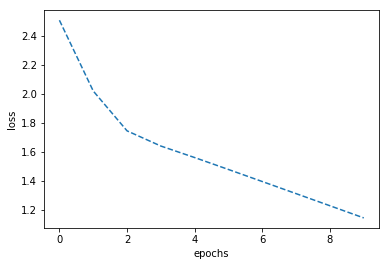

In [68]:
plt.plot(losses, linestyle = "--")
plt.xlabel("epochs")
plt.ylabel("loss")

0.9999999568648903


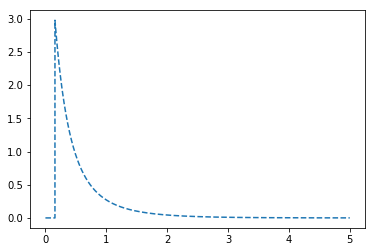

In [132]:
import numpy as np
#t = torch.linspace(0,100)
t = torch.linspace(0,5,100000)
tj = torch.tensor([0.1567])
hj = torch.tensor([1.56])
marker = torch.tensor([0.])
nf = rnn.normalization_factor(tj,hj)
fstar = rnn.fstart(t,tj,hj).detach().numpy()
delta = t.numpy()[1] - t.numpy()[0]
integrale_ = np.sum(fstar[1:] + fstar[:-1])/2 * delta
fstar  = fstar/integrale_
import matplotlib.pyplot as plt
integrale__ = np.sum(fstar[1:] + fstar[:-1])/2 * delta
print(integrale__)

plt.plot(t.numpy(),fstar, linestyle = "--")

# Tick.Hawkes

In [17]:
from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelSumExp
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/tick/base/__init__.py:18: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


#### 1 dimensional Hawkes process simulation using tick

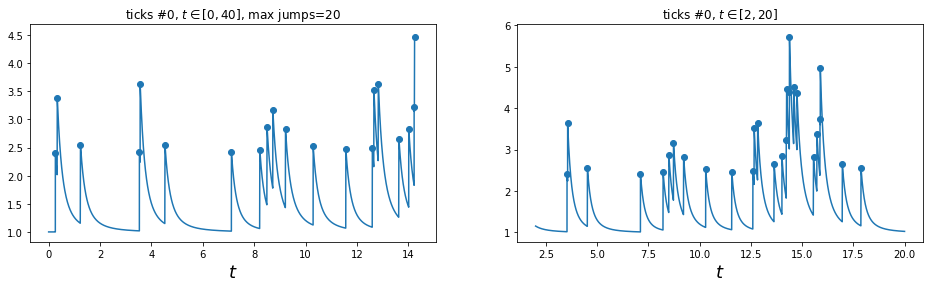

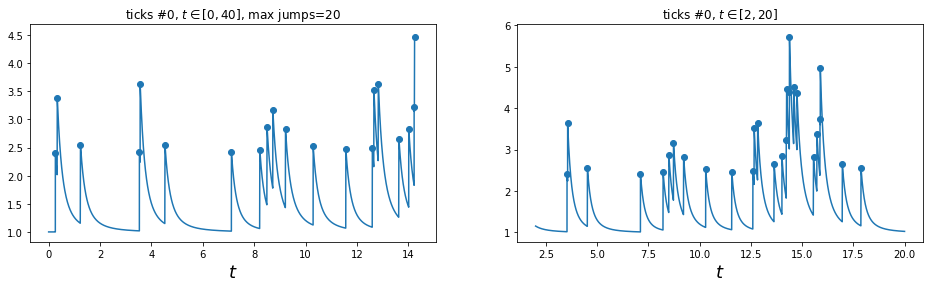

In [18]:
run_time = 40

hawkes = SimuHawkes(n_nodes=1, end_time=run_time, verbose=False, seed=1398)
kernel1 = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
hawkes.set_kernel(0, 0, kernel1)
hawkes.set_baseline(0, 1.)

dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()
timestamps = hawkes.timestamps
intensity = hawkes.tracked_intensity
intensity_times = hawkes.intensity_tracked_times

_, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_point_process(hawkes, n_points=50000, t_min=0, max_jumps=20, ax=ax[0])
plot_point_process(hawkes, n_points=50000, t_min=2, t_max=20, ax=ax[1])

In [19]:
def simulate_timestamps(end_time):
    # simulation 2 types of event for exemple selling or buying
    
    hawkes = SimuHawkes(n_nodes=2, end_time=end_time, verbose=False, seed=1398)
    kernel = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
    kernel1 = HawkesKernelSumExp([.2, .3, .1], [1., 3., 7.])
    
    hawkes.set_kernel(0, 0, kernel)
    hawkes.set_kernel(0, 1, kernel)
    hawkes.set_kernel(1, 0, kernel)
    hawkes.set_kernel(1, 1, kernel)
    
    hawkes.set_baseline(0, .8)
    hawkes.set_baseline(1, 1.)

    dt = 0.1
    hawkes.track_intensity(dt)
    hawkes.simulate()
    timestamps = hawkes.timestamps
    t0 = timestamps[0]
    t1 = timestamps[1]
    
    t = []
    marker = []
    n0 = len(t0)
    n1 = len(t1)
    i = 0
    j = 0
    while(i<n0 and j<n1):
        if(t0[i]<t1[j]):
            t.append(t0[i])
            marker.append(0)
            i += 1
        else:
            t.append(t1[j])
            marker.append(1)
            j += 1
    if(i==n0):
        for k in range(n0,n1):
            t.append(t1[k])
            marker.append(1)
    else:
        for k in range(n1,n0):
            t.append(t0[k])
            marker.append(0)
        
        
   
    return t,marker


 

In [343]:
simulate_timestamps(end_time=2000)[0]

[0.1453998273553042,
 0.1841744724280548,
 0.5910960339190892,
 1.5677640924338307,
 1.5824299252948109,
 1.9706387517435,
 2.930921868725349,
 3.69765316580875,
 3.828242832851533,
 3.8690278220013226,
 3.9924803129182216,
 4.109933597350456,
 4.2349385311236345,
 4.528839214780729,
 4.8825305589309345,
 4.906513499400947,
 4.973537632659001,
 5.212763731186806,
 5.331627287925645,
 5.400715155736202,
 5.406657026117649,
 5.454771623071175,
 5.456594504809564,
 5.530331730185287,
 5.578008222492138,
 5.776994557096648,
 5.819088834084263,
 5.855813817764325,
 5.8574804773489895,
 5.860791449431528,
 6.1324627680639185,
 6.347360651207286,
 6.972644024344269,
 7.083367739295406,
 7.210046934473388,
 7.371146157026261,
 7.4045067574341275,
 7.4175271740402025,
 7.459357874777104,
 7.563767041208158,
 7.606555100513292,
 7.679454924040601,
 7.773057141798235,
 7.781373919771833,
 7.813868599569604,
 7.836330879915978,
 7.84895889372964,
 7.879810941526391,
 7.881163676710684,
 7.88976214